# 1.2 使用torch.nn实现二维卷积，并在至少一个数据集上进行实验，从训练时间、预测精度、Loss变化等角度分析实验结果（最好使用图表展示）

Epoch 1/15, Loss: 0.5680, Accuracy: 74.19%, Time: 3.74s
Epoch 2/15, Loss: 0.3078, Accuracy: 88.29%, Time: 3.74s
Epoch 3/15, Loss: 0.1955, Accuracy: 92.44%, Time: 3.59s
Epoch 4/15, Loss: 0.1564, Accuracy: 93.73%, Time: 3.71s
Epoch 5/15, Loss: 0.1238, Accuracy: 95.30%, Time: 3.78s
Epoch 6/15, Loss: 0.0976, Accuracy: 96.68%, Time: 3.63s
Epoch 7/15, Loss: 0.0911, Accuracy: 96.77%, Time: 3.61s
Epoch 8/15, Loss: 0.0540, Accuracy: 98.43%, Time: 3.64s
Epoch 9/15, Loss: 0.0258, Accuracy: 99.17%, Time: 3.58s
Epoch 10/15, Loss: 0.0312, Accuracy: 99.08%, Time: 3.49s
Epoch 11/15, Loss: 0.0242, Accuracy: 99.08%, Time: 3.42s
Epoch 12/15, Loss: 0.0159, Accuracy: 99.45%, Time: 3.50s
Epoch 13/15, Loss: 0.0103, Accuracy: 99.63%, Time: 3.41s
Epoch 14/15, Loss: 0.0125, Accuracy: 99.63%, Time: 3.43s
Epoch 15/15, Loss: 0.0087, Accuracy: 99.63%, Time: 3.39s


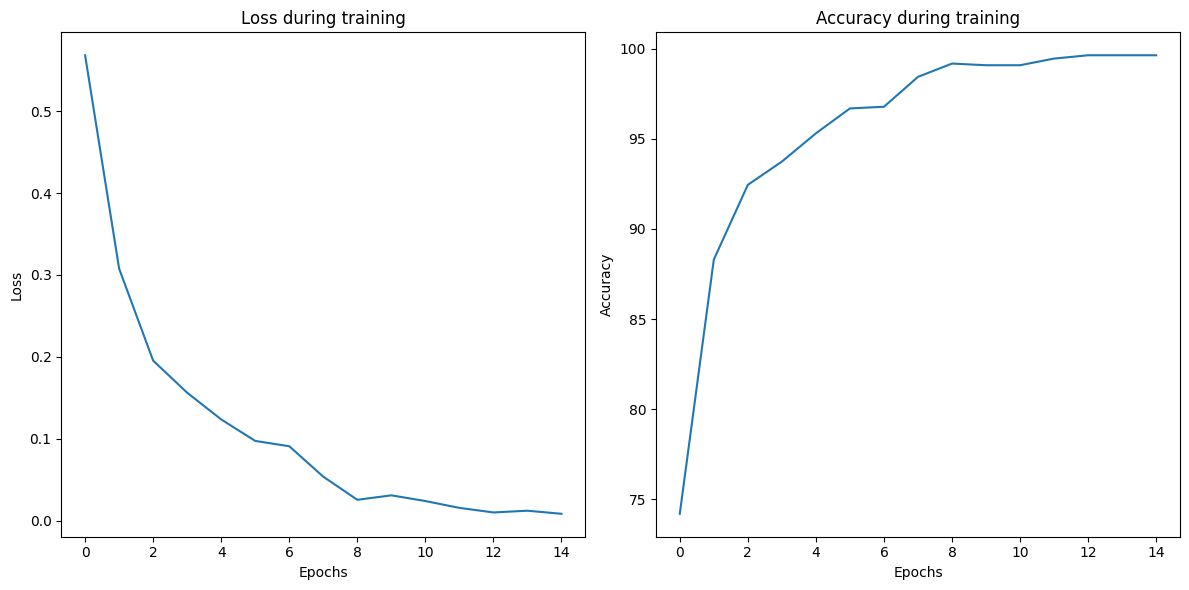

In [27]:
import os
import numpy as np
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import transforms
from PIL import Image
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time

# 数据加载与预处理
class VehicleDataset(data.Dataset):
    def __init__(self, img_paths, labels, transform=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.img_paths)
    
    def __getitem__(self, idx):
        img = Image.open(self.img_paths[idx])
        if self.transform:
            img = self.transform(img)
        
        label = self.labels[idx]
        return img, label

# 预处理步骤，包括调整图片大小和归一化
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# 加载数据
def load_data(data_dir, test_size=0.2):# 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    labels = {'car': 0, 'bus': 1, 'truck': 2}
    img_paths = []
    img_labels = []

    # 遍历每个类别
    for label_name, label in labels.items():
        class_path = os.path.join(data_dir, label_name)
        for img_name in os.listdir(class_path):
            # 忽略隐藏文件和非图像文件
            if img_name.startswith('.') or not img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                continue
            img_path = os.path.join(class_path, img_name)
            img_paths.append(img_path)
            img_labels.append(label)

    # 划分训练集和测试集，随机抽取20-30%的数据作为测试集
    X_train, X_test, y_train, y_test = train_test_split(img_paths, img_labels, test_size=test_size, stratify=img_labels)
    
    train_dataset = VehicleDataset(X_train, y_train, transform)
    test_dataset = VehicleDataset(X_test, y_test, transform)
    
    return train_dataset, test_dataset

# torch.nn定义卷积神经网络模型
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(8 * 64 * 64, 128)
        self.fc2 = nn.Linear(128, 3)  # 3个类别

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # 卷积层 + ReLU 激活 + 池化
        x = x.view(-1, 8 * 64 * 64)  # 展开为全连接层的输入
        x = torch.relu(self.fc1(x))  # 全连接层 + ReLU
        x = self.fc2(x)  # 输出层
        return x

# 训练函数
def train_model(train_loader, test_loader, model, criterion, optimizer, epochs=5):
    loss_history = []
    accuracy_history = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0
        start_time = time.time()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # 计算准确率
            _, predicted = torch.max(outputs.data, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        avg_loss = running_loss / len(train_loader)
        accuracy = 100 * correct_predictions / total_samples
        loss_history.append(avg_loss)
        accuracy_history.append(accuracy)

        epoch_time = time.time() - start_time
        print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%, Time: {epoch_time:.2f}s')
    
    return loss_history, accuracy_history

# 设置数据集路径
data_dir = r"C:\Users\37623\jupyter_test\Lab4\datasets\Vehicle_classification_dataset"

# 加载数据
train_dataset, test_dataset = load_data(data_dir)

# 使用DataLoader加载训练集和测试集
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

# 初始化模型、损失函数和优化器
model = ConvNet()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# 训练模型
loss_history, accuracy_history = train_model(train_loader, test_loader, model, criterion, optimizer, epochs=15)

# 绘制训练结果图
def plot_training_history(loss_history, accuracy_history):
    plt.figure(figsize=(12, 6))

    # 绘制损失曲线
    plt.subplot(1, 2, 1)
    plt.plot(loss_history, label='Loss')
    plt.title('Loss during training')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')

    # 绘制准确率曲线
    plt.subplot(1, 2, 2)
    plt.plot(accuracy_history, label='Accuracy')
    plt.title('Accuracy during training')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')

    plt.tight_layout()
    plt.show()

# 绘制训练损失和准确率曲线
plot_training_history(loss_history, accuracy_history)
